In [1]:
#Import all the needed packages:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy
import cartopy as cp
import cartopy.crs as ccrs
import torch.nn as nn
import random
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_squared_error as Mse

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR 1: PROJ: proj_create_from_database: Open of /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/share/proj failed


In [ ]:
#set up cpu usage
device_name = torch.cuda.get_device_name(0)
device = torch.device('cuda:0')

## Data Loading and visualization

In this section, the data used as input variables for the U-Net (2m air temperature (t2m), 10m u- and v-component of wind (u10, v10) and sea surface temperature (SST) of the ERA5 Reanalysis data and SIC of the ORAS5 Reanalysis data) is loaded and visualized.\

Beforehand, the data was processed using cdo to a latitude longitude grid of 64° x 128°. The used cdo commands are the following:\
Create a .nc file of all SIC files after downloading the data: `cdo mergetime ice_conc_sh_ease2-250_cdr-v2p0_* ice_` \
Create monthly means of the ERA5 data: `cdo -b F64 mergetime -setctomiss,inf ERA5_monmean_*.nc ERA5_monmean_19792023.nc`\
Bring both files to same grid of ERA5 data: `cdo remapbil,grid_ERA5.nc ice_conc.nc ice_conc_grid.n`\
Bring files to coarse resolution:`cdo remapbil,grid_coarse.txt ice_conc_ORAS5_grid.nc ice_conc_ORAS5_coarse.n` \
The I wrote the grid_coarse.txt file myself to downscale the resolution for saving computational time. Tis file and the processed data can be found at: 

In [3]:
#load data with coarse resolution:
data_coarse = xr.open_dataset('ERA5_monmean_19792023_coarse.nc', decode_times=True)
sic_coarse = xr.open_dataset('ice_conc_ORAS5_coarse.nc')

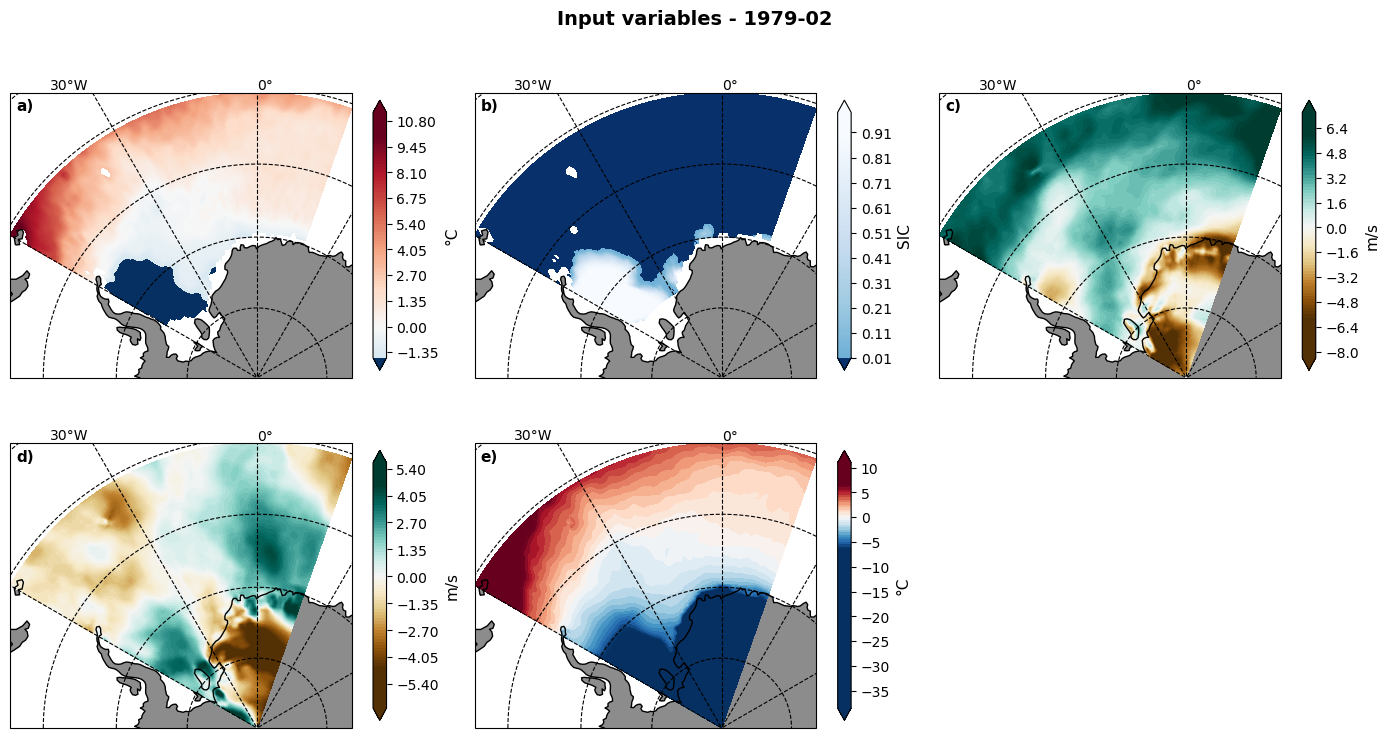

In [8]:
#Create a subplot with all input variables:

fig = plt.figure(figsize=(14,8), tight_layout=True)
ax1 = plt.subplot(2,3,1, projection=ccrs.SouthPolarStereo())
ax2 = plt.subplot(2,3,2, projection=ccrs.SouthPolarStereo())
ax3 = plt.subplot(2,3,3, projection=ccrs.SouthPolarStereo())
ax4 = plt.subplot(2,3,4, projection=ccrs.SouthPolarStereo())
ax5 = plt.subplot(2,3,5, projection=ccrs.SouthPolarStereo())

axes = [ax1, ax2, ax3, ax4, ax5]
text = ['a)', 'b)', 'c)', 'd)', 'e)']
colors = ['RdBu_r', 'Blues_r', 'BrBG', 'BrBG', 'RdBu_r']
dataset = [data_coarse, sic_coarse, data_coarse, data_coarse, data_coarse]
ts = 1 #time stamp
variable = [data_coarse.sst[ts,:,:]-273.15, sic_coarse.ileadfra[ts,:,:], data_coarse.u10[ts,:,:], data_coarse.v10[ts,:,:], data_coarse.t2m[ts,:,:]-273.15]
lbl = ['°C', 'SIC', 'm/s', 'm/s', '°C']
texts = [AnchoredText('a)', loc=2, borderpad=0., prop={'size': 11, 'fontweight': 'bold'}, frameon=False), 
         AnchoredText('b)', loc=2, borderpad=0., prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
         AnchoredText('c)', loc=2, borderpad=0., prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
         AnchoredText('d)', loc=2, borderpad=0., prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
         AnchoredText('e)', loc=2, borderpad=0., prop={'size': 11, 'fontweight': 'bold'}, frameon=False)]

for i in range(5):
    gl = axes[i].gridlines(color='k', linestyle = 'dashed', draw_labels=False, dms=True, x_inline=False, y_inline=True)
    gl.top_labels = True
    gl.xlabel_style = {'rotation':0}
    axes[i].add_feature(cp.feature.LAND, zorder=1, facecolor='grey', alpha=0.9)
    
    p = axes[i].contourf(dataset[i].lon, dataset[i].lat, variable[i], levels=100, vmin = -abs(np.max(variable[i]))+((np.max(variable[i])+abs(np.min(variable[i])))/10),
                         vmax = abs(np.max(variable[i]))-((np.max(variable[i])+abs(np.min(variable[i])))/10), extend = 'both', transform=ccrs.PlateCarree(), 
                         cmap=plt.get_cmap(colors[i]))
    cbar = (plt.colorbar(p, orientation='vertical', shrink=0.7).set_label(label=lbl[i],size=11))
    axes[i].coastlines()
    axes[i].add_artist(texts[i])

fig.suptitle('Input variables - {}'.format(str(sic_coarse.time_counter.values[ts])[0:7]), fontsize=14, fontweight='bold')
plt.savefig('Input_data.png', dpi=300)
plt.show()

## Data preparation

In this section, the data is prepared depending on the wanted lead time. For lead time one month, input variables have to end one month before output variables. For two months and three monts lead time, they have to end two month and three months before the output. The output has to start one month, two months or three months after the input variables for lead times of one, two and three months respectively.

In [4]:
def data_preparation(lead_time):
    
    t= lead_time-1
    #Load all the variables with the correct time_axis of the prediction and lead time
    #lead time:   1 month,       input variables: [:455], sic[3:456]
    #lead time:   2 months,      input variables: [:454], sic[4:456]
    #lead time:   3 months,      input variables: [:453], sic[5:456]
    
    #cut the data to the correct legth and normalize them:
    sst = data_coarse.sst.data[:455-t,:,:]
    t2m = data_coarse.t2m.data[:455-t,:,:]
    u10 = data_coarse.u10.data[:455-t,:,:]
    v10 = data_coarse.v10.data[:455-t,:,:]
    sic_in = sic_coarse.ileadfra.data[:455-t,:,:]
    sic_out = sic_coarse.ileadfra.data[3+t:456,:,:]
    y_times = sic_coarse.time_counter[3+t:456]
    
    #normalize the data:
    sst_norm = (sst - np.nanmean(sst)) / np.nanstd(sst)
    t2m_norm = (t2m - np.nanmean(t2m)) / np.nanstd(t2m)
    u10_norm = (u10 - np.nanmean(u10)) / np.nanstd(u10)
    v10_norm = (v10 - np.nanmean(v10)) / np.nanstd(v10)
    sic_in_norm = (sic_in - np.nanmean(sic_in)) / np.nanstd(sic_in)
    sic_out_norm = (sic_out - np.nanmean(sic_out)) / np.nanstd(sic_out)
    
    #store the std of the sic y values:
    sic_std = np.nanstd(sic_out)
    sic_mean = np.nanmean(sic_out)
    
    #create a mask where NaN values are to later set the NaN values again:
    mask = torch.tensor(~np.isnan(sic_out)).float()
    mask[mask==0] = np.nan
    
    #create masked arrays, where NaN values are set to -mean/std and store them in the gpu:
    x_sst = torch.nan_to_num(torch.tensor(sst_norm, dtype=torch.float32, device='cpu'), (- np.nanmean(sst) / np.nanstd(sst))).to(device)
    x_t2m = torch.nan_to_num(torch.tensor(t2m_norm, dtype=torch.float32, device='cpu'), (- np.nanmean(t2m) / np.nanstd(t2m))).to(device)
    x_u10 = torch.nan_to_num(torch.tensor(u10_norm, dtype=torch.float32, device='cpu'), (- np.nanmean(u10) / np.nanstd(u10))).to(device)
    x_v10 = torch.nan_to_num(torch.tensor(v10_norm, dtype=torch.float32, device='cpu'), (- np.nanmean(v10) / np.nanstd(v10))).to(device)
    x_sic = torch.nan_to_num(torch.tensor(sic_in_norm, dtype=torch.float32, device='cpu'), (- np.nanmean(sic_in) / np.nanstd(sic_in))).to(device)
    y_sic = torch.nan_to_num(torch.tensor(sic_out_norm, dtype=torch.float32, device='cpu'), (- np.nanmean(sic_out) / np.nanstd(sic_out))).to(device)
    
    input_variables = [x_sst, x_t2m, x_u10, x_v10, x_sic]
    
    
    return input_variables, y_sic, sic_std, sic_mean, mask, y_times

## U-Net

The U-Net is a Convolutional Neural Network (CNN) with a down-sampling and an up-sampling path and skip connections between the paths. In this section, the different components of the U-Net are coded and used to build the U-Net function. The downsampling path is called the encoder, the up-sampling path the decoder in the following.

#### Convolutional block:

The convolutional blocks are part of the encoder and decoder. They consist of two 3x3 convolutions, followed by a batch normalization and a non-linear ReLU activation function.

In [5]:
## Convolutions of 3x3, batch normalization, non-linearity:ReLu
class convolution(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

#### Encoder block

The Encoder block uses the convolutional block and afterwards applies a 2x2 max pooling layer. This reduces the dimensions by half and doubles the number of filters.

In [6]:
## use of the convolution, afterwards a max pooling of dimension 2x2 (number of filters doubles, heigt and wisth half after every block
class encoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = convolution(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

#### Decoder block

The Decoder block uses the convolutional block, but includes a skip connection. Skip connections are used to reintroduce high-resolution information, that
was filtered out in the down-sampling path. Between the convolutional layers are transposed convolutions, that decrease the number of filters by half and doubles the dimensions.

In [7]:
## transpose convolution (upsampling of the data), concatenation with the skip connection from the encoder, convolution 
## (number of filters decreases by half and height and width doubles)
class decoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = convolution(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

#### Build the U-Net

In this section, the U-Net is build using the convolutional, decoder and encoder blocks. The input channels are set as a variable to allow using the Network for different sizes of input channels, i.e. for all 5 variables, only one and only two variables.

In [8]:
class UNet(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()

        """ Encoder """
        self.e1 = encoder(input_channels, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        """ Bottleneck """
        self.b = convolution(512, 1024)

        """ Decoder """
        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

## Testing, Validation and training datasets

In this section, testing, training and validation datasers are created depending on the wanted lead time and the wanted input variables. This function can create testing, validation and training datasets for all variables, one variable (that has to be specified with `n_input_variable` and `index_input_var`) and two variables (that has to be specified with `n_input_variable`, `index_input_var1` and `index_input_var2`). This function returns the data loaders.

The indices for the input variables are the following: `sst = 0`, `t2m=1`, `u10=2`, `v10=3`, `sic=4`

In [9]:
def dataset_creation_correct(lead_time, n_input_variables=False, index_input_var1=False, index_input_var2=False):
    
    ### load the data depending on the lead time (they have correct length and must oly cut to the months:
    input_variables, y_sic, sic_std, sic_mean, mask, y_times = data_preparation(lead_time)
    
    #input_variables = [x_sst, x_t2m, x_u10, x_v10, x_sic]
    if n_input_variables == 1:
        x_input = torch.stack((input_variables[index_input_var1][2:], input_variables[index_input_var1][1:-1], 
                               input_variables[index_input_var1][:-2]), axis = 1)
    elif n_input_variables == 2:
        x_input = torch.stack((input_variables[index_input_var1][2:], input_variables[index_input_var1][1:-1], 
                               input_variables[index_input_var1][:-2],
                               input_variables[index_input_var2][2:], input_variables[index_input_var2][1:-1], 
                               input_variables[index_input_var2][:-2]), axis = 1)
    
    #### stack together three months of each variables the lead time before the sic:
    else:
        x_input = torch.stack((input_variables[0][2:], input_variables[0][1:-1], input_variables[0][:-2], 
                           input_variables[1][2:], input_variables[1][1:-1], input_variables[1][:-2], 
                           input_variables[2][2:], input_variables[2][1:-1], input_variables[2][:-2], 
                           input_variables[3][2:], input_variables[3][1:-1], input_variables[3][:-2], 
                           input_variables[4][2:], input_variables[4][1:-1], input_variables[4][:-2]), axis = 1)
    
    y_input = torch.unsqueeze(y_sic, 1)
    
    ### create training and validation variables:
    x_trainval = x_input[:408,:,:,:]
    y_trainval = y_input[:408,:,:,:]
    
    
    ### create testing variables:
    x_test = x_input[408:,:,:,:]
    y_test = y_input[408:,:,:,:]

    
    ### create datasets:
    training = 0.75
    validation = 0.25
    
    dataset_trainval = torch.utils.data.random_split(TensorDataset(x_trainval, y_trainval), [training, validation])  #splitted training and validation set
    dataset_test = TensorDataset(x_test, y_test)        #testing set
    
    #create dataloaders for all datasets with reproducibility:
    manualSeed=227
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True)
    
    data_loader_train = DataLoader(dataset_trainval[0], batch_size=50, shuffle=True)
    data_loader_valid = DataLoader(dataset_trainval[1], batch_size=50, shuffle=True)
    data_loader_test = DataLoader(dataset_test, batch_size=48-lead_time-1, shuffle=False)
    
    return data_loader_train, data_loader_valid, data_loader_test, x_test

## Hyperparameter tuning

In this section, functions are defined for hyperparameter tuning. Different setups of Optimizers (Adam and Stochadtic Gradient Descent (SGD)), learining rates (0.001, 0.005, 0,01) are tested and evaluated on mean square error on the training data set. 

#### Training Loop for optimizer

In [11]:
def Training_loop_optim(n_channels, n_epochs, learning_rate, lossfct, optimi, data_loader_train, data_loader_valid, manualSeed =27):
    
    # Set random seed for reproducibility
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results

    conv = UNet(input_channels=n_channels).to(device)
    lossfunc = lossfct
    optimizer = optimi(conv.parameters(), lr=learning_rate)
    
    Loss_valid, Loss_train = [], []

    for epoch in tqdm(range(n_epochs)):
        conv.train()

        for batch_index, batch in enumerate(data_loader_train):
            x_batch, y_batch = batch
            optimizer.zero_grad()

            yhat_batch = conv(x_batch)
            loss_train = lossfunc(yhat_batch, y_batch)
            
            Loss_train.append(loss_train.detach().cpu())
            
            loss_train.backward()
            torch.no_grad()
            optimizer.step()

        conv.eval()
        with torch.no_grad():
            temp = []
            for batch_index, batch in enumerate(data_loader_valid):
                x_batch, y_batch = batch
                yhat_batch = conv(x_batch)
                loss_valid = lossfunc(yhat_batch, y_batch)
                temp.append(loss_valid.detach().cpu())
            mean = np.mean(temp)
            Loss_valid.append(mean)
            
        #save the models best state:
        if min(Loss_valid) == Loss_valid[epoch]:
            best_epoch = epoch
            best_state = deepcopy(conv.state_dict())            
    print('Epoch of minimum validation Loss: ', best_epoch)
    
    #store the models best state into a network:
    best_unet = UNet(input_channels=n_channels).to(device)
    best_unet.load_state_dict(best_state)

    return best_unet, best_state, Loss_train, Loss_valid

#### Testing loop for optimizer

In [12]:
def Testing_loop_optim(best_unet, best_state, data_loader_test):
    best_unet.load_state_dict(best_state)

    #loss function
    lossfunc = torch.nn.MSELoss()

    #start evaluating the model
    best_unet.eval()
    with torch.no_grad():
        for batch_index, batch in enumerate(data_loader_test):
            x_batch, y_batch = batch
            yhat_batch = best_unet(x_batch)
            loss_test = lossfunc(yhat_batch, y_batch)
    
    print('MSE: ', loss_test)
    
    return loss_test

#### Optimizer function

In [13]:
def Optimization_Loop(n_channels, n_epochs, lead_time, name_bestState, name_MSE_Setup):
        
    LR = [0.001, 0.005, 0.01]
    Opt = [torch.optim.Adam, torch.optim.SGD]
    Lossfct = [torch.nn.L1Loss(), torch.nn.MSELoss()]
    
    MSE, Best_Unet, Best_state, Setup, Loss_v, Loss_tr = [], [], [], [], [], []
    
    for optimi in Opt:
        for lossfct in Lossfct:
            for learning_rate in LR:
                print('Optimizer = {}, Loss function = {}, Learning rate = {}'.format(optimi, lossfct, learning_rate))
                best_unet, best_state, Loss_train, Loss_valid = Training_loop_optim(n_channels, n_epochs, learning_rate,
                                                                                    lossfct, optimi, data_loader_train, data_loader_valid,manualSeed=227727)
                loss_test = Testing_loop_optim(best_unet, best_state, data_loader_test)
                MSE.append(loss_test.detach().cpu())
                Setup.append('Optimizer = {}, Loss function = {}, Learning rate = {}'.format(optimi, lossfct,learning_rate))
                Best_Unet.append(best_unet)
                Best_state.append(best_state)
                Loss_tr.append(Loss_train)
                Loss_v.append(Loss_valid)

    best = np.where(MSE == np.min(MSE))[0][0]
    print('BEST SETUP =:', Setup[best])
    Best_Unet[best].load_state_dict(Best_state[best]) #load the best state
    torch.save(Best_Unet[best].state_dict(), name_bestState) #save the best state
    
    #save MSE, Setup:
    with open(name_MSE_Setup, 'wb') as f:
        np.save(f, MSE)
        np.save(f, Setup)
    
    return Best_Unet[best], Best_state[best], Loss_tr[best], Loss_v[best], x_test

#### Results of the Hyperparameter tuning:

##### Optimization for all variables:

In [15]:
data_loader_train, data_loader_valid, data_loader_test, x_test = dataset_creation_correct(lead_time=1)
best_unet, best_state, Loss_train, Loss_valid, x_test = Optimization_Loop(n_channels=15, n_epochs=800, lead_time= 1,
                                                                          name_bestState='model_best_state.pt', name_MSE_Setup= 'Optim_ld1.npy')

with open('Optim_TrainValid_ld1_withSIC.npy', 'wb') as f:
    np.save(f, Loss_train)
    np.save(f, Loss_valid)

torch.Size([408, 15, 64, 128])
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = L1Loss(), Learning rate = 0.001


100%|██████████| 800/800 [08:56<00:00,  1.49it/s]


Epoch of minimum validation Loss:  122
MSE:  tensor(0.0238, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = L1Loss(), Learning rate = 0.005


100%|██████████| 800/800 [08:57<00:00,  1.49it/s]


Epoch of minimum validation Loss:  711
MSE:  tensor(0.0257, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = L1Loss(), Learning rate = 0.01


100%|██████████| 800/800 [04:33<00:00,  2.92it/s]


Epoch of minimum validation Loss:  728
MSE:  tensor(0.0274, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = MSELoss(), Learning rate = 0.001


100%|██████████| 800/800 [04:08<00:00,  3.21it/s]


Epoch of minimum validation Loss:  249
MSE:  tensor(0.0226, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = MSELoss(), Learning rate = 0.005


100%|██████████| 800/800 [04:09<00:00,  3.21it/s]


Epoch of minimum validation Loss:  557
MSE:  tensor(0.0253, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = MSELoss(), Learning rate = 0.01


100%|██████████| 800/800 [04:35<00:00,  2.91it/s]


Epoch of minimum validation Loss:  195
MSE:  tensor(0.0228, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.001


100%|██████████| 800/800 [04:19<00:00,  3.08it/s]


Epoch of minimum validation Loss:  786
MSE:  tensor(0.0286, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.005


100%|██████████| 800/800 [04:18<00:00,  3.10it/s]


Epoch of minimum validation Loss:  795
MSE:  tensor(0.0224, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.01


100%|██████████| 800/800 [04:42<00:00,  2.83it/s]


Epoch of minimum validation Loss:  796
MSE:  tensor(0.0265, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.001


100%|██████████| 800/800 [04:43<00:00,  2.83it/s]


Epoch of minimum validation Loss:  680
MSE:  tensor(0.0295, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.005


100%|██████████| 800/800 [03:57<00:00,  3.38it/s]


Epoch of minimum validation Loss:  557
MSE:  tensor(0.0235, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.01


100%|██████████| 800/800 [04:03<00:00,  3.28it/s]


Epoch of minimum validation Loss:  680
MSE:  tensor(0.0273, device='cuda:0')
BEST SETUP =: Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.005


##### Optimization for all variables, lead time 2 months

In [16]:
data_loader_train, data_loader_valid, data_loader_test, x_test = dataset_creation_correct(lead_time=2)
best_unet_ld2, best_state_ld2, Loss_train_ld2, Loss_valid_ld2, x_test_ld2 = Optimization_Loop(n_channels=15, n_epochs=900, lead_time= 2, 
                                                                                              name_bestState='model_best_state_ld2.pt', name_MSE_Setup= 'Optim_ld2.npy')

with open('Optim_TrainValid_ld2_withSIC.npy', 'wb') as f:
    np.save(f, Loss_train_ld2)
    np.save(f, Loss_valid_ld2)

torch.Size([408, 15, 64, 128])
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = L1Loss(), Learning rate = 0.001


100%|██████████| 900/900 [04:53<00:00,  3.06it/s]


Epoch of minimum validation Loss:  207
MSE:  tensor(0.0521, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = L1Loss(), Learning rate = 0.005


100%|██████████| 900/900 [05:21<00:00,  2.80it/s]


Epoch of minimum validation Loss:  810
MSE:  tensor(0.0557, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = L1Loss(), Learning rate = 0.01


100%|██████████| 900/900 [05:30<00:00,  2.73it/s]


Epoch of minimum validation Loss:  287
MSE:  tensor(0.0522, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = MSELoss(), Learning rate = 0.001


100%|██████████| 900/900 [05:38<00:00,  2.66it/s]


Epoch of minimum validation Loss:  124
MSE:  tensor(0.0447, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = MSELoss(), Learning rate = 0.005


100%|██████████| 900/900 [05:38<00:00,  2.66it/s]


Epoch of minimum validation Loss:  576
MSE:  tensor(0.0519, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = MSELoss(), Learning rate = 0.01


100%|██████████| 900/900 [05:38<00:00,  2.66it/s]


Epoch of minimum validation Loss:  207
MSE:  tensor(0.0497, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.001


100%|██████████| 900/900 [05:18<00:00,  2.82it/s]


Epoch of minimum validation Loss:  834
MSE:  tensor(0.0455, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.005


100%|██████████| 900/900 [04:59<00:00,  3.00it/s]


Epoch of minimum validation Loss:  832
MSE:  tensor(0.0473, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.01


100%|██████████| 900/900 [04:37<00:00,  3.25it/s]


Epoch of minimum validation Loss:  813
MSE:  tensor(0.0491, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.001


100%|██████████| 900/900 [04:29<00:00,  3.33it/s]


Epoch of minimum validation Loss:  829
MSE:  tensor(0.0447, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.005


100%|██████████| 900/900 [04:49<00:00,  3.11it/s]


Epoch of minimum validation Loss:  355
MSE:  tensor(0.0446, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.01


100%|██████████| 900/900 [05:03<00:00,  2.97it/s]


Epoch of minimum validation Loss:  244
MSE:  tensor(0.0490, device='cuda:0')
BEST SETUP =: Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.005


##### Optimization for all variables, lead time 3 months

In [19]:
data_loader_train, data_loader_valid, data_loader_test, x_test = dataset_creation_correct(lead_time=3)
best_unet_ld3, best_state_ld3, Loss_train_ld3, Loss_valid_ld3, x_test_ld3 = Optimization_Loop(n_channels=15, n_epochs=800, lead_time= 3, 
                                                                                              name_bestState='model_best_state_ld3.pt', name_MSE_Setup= 'Optim_ld3.npy')

with open('Optim_TrainValid_ld3_withSIC.npy', 'wb') as f:
    np.save(f, Loss_train_ld3)
    np.save(f, Loss_valid_ld3)

torch.Size([408, 15, 64, 128])
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = L1Loss(), Learning rate = 0.001


100%|██████████| 800/800 [04:09<00:00,  3.21it/s]


Epoch of minimum validation Loss:  177
MSE:  tensor(0.0851, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = L1Loss(), Learning rate = 0.005


100%|██████████| 800/800 [04:09<00:00,  3.21it/s]


Epoch of minimum validation Loss:  216
MSE:  tensor(0.0618, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = L1Loss(), Learning rate = 0.01


100%|██████████| 800/800 [04:09<00:00,  3.21it/s]


Epoch of minimum validation Loss:  653
MSE:  tensor(0.0806, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = MSELoss(), Learning rate = 0.001


100%|██████████| 800/800 [04:09<00:00,  3.21it/s]


Epoch of minimum validation Loss:  349
MSE:  tensor(0.0642, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = MSELoss(), Learning rate = 0.005


100%|██████████| 800/800 [04:09<00:00,  3.21it/s]


Epoch of minimum validation Loss:  632
MSE:  tensor(0.0665, device='cuda:0')
Optimizer = <class 'torch.optim.adam.Adam'>, Loss function = MSELoss(), Learning rate = 0.01


100%|██████████| 800/800 [04:08<00:00,  3.22it/s]


Epoch of minimum validation Loss:  186
MSE:  tensor(0.0660, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.001


100%|██████████| 800/800 [03:54<00:00,  3.41it/s]


Epoch of minimum validation Loss:  677
MSE:  tensor(0.0699, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.005


100%|██████████| 800/800 [03:54<00:00,  3.41it/s]


Epoch of minimum validation Loss:  775
MSE:  tensor(0.0755, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = L1Loss(), Learning rate = 0.01


100%|██████████| 800/800 [03:53<00:00,  3.42it/s]


Epoch of minimum validation Loss:  533
MSE:  tensor(0.0846, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.001


100%|██████████| 800/800 [03:54<00:00,  3.42it/s]


Epoch of minimum validation Loss:  691
MSE:  tensor(0.0595, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.005


100%|██████████| 800/800 [03:53<00:00,  3.42it/s]


Epoch of minimum validation Loss:  483
MSE:  tensor(0.0714, device='cuda:0')
Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.01


100%|██████████| 800/800 [03:53<00:00,  3.42it/s]


Epoch of minimum validation Loss:  483
MSE:  tensor(0.0706, device='cuda:0')
BEST SETUP =: Optimizer = <class 'torch.optim.sgd.SGD'>, Loss function = MSELoss(), Learning rate = 0.001


### Testing for most important variable:

In this section, the most important input variables are figured out.

In [10]:
def bestVariables(n_channels, n_epochs, learning_rate, lossfct, optimi,lead_time,name_bestState, manualSeed =27, var1_index=False, input_variables=1):
    
    length = [0,1,2,3,4]
    if input_variables==2:
        length = np.delete(length, var1_index)
    
    variables = ['sst', 't2m', 'u10', 'v10', 'sic']
    MSE, Best_Unet, Best_state, Setup, Loss_v, Loss_tr, X_test = [], [], [], [], [], [], []
    
    for i in length:
        
        if input_variables ==2:
            data_loader_train, data_loader_valid, data_loader_test, x_test = dataset_creation_correct(lead_time, input_variables, var1_index, i)
        
        else:
            data_loader_train, data_loader_valid, data_loader_test, x_test = dataset_creation_correct(lead_time, input_variables, i)
        
        ##### Training:
        
        # Set random seed for reproducibility
        random.seed(manualSeed)
        torch.manual_seed(manualSeed)
        torch.use_deterministic_algorithms(True) # Needed for reproducible results

        conv =UNet(input_channels=n_channels).to(device)
        lossfunc = lossfct
        optimizer = optimi(conv.parameters(), lr=learning_rate)
        Loss_valid, Loss_train = [], []

        for epoch in tqdm(range(n_epochs)):
            conv.train()

            for batch_index, batch in enumerate(data_loader_train):
                x_batch, y_batch = batch
                optimizer.zero_grad()

                yhat_batch = conv(x_batch)
                loss_train = lossfunc(yhat_batch, y_batch)

                Loss_train.append(loss_train.detach().cpu())

                loss_train.backward()
                torch.no_grad()
                optimizer.step()

            conv.eval()
            with torch.no_grad():
                temp = []
                for batch_index, batch in enumerate(data_loader_valid):
                    x_batch, y_batch = batch
                    yhat_batch = conv(x_batch)
                    loss_valid = lossfunc(yhat_batch, y_batch)
                    temp.append(loss_valid.detach().cpu())
                mean = np.mean(temp)
                Loss_valid.append(mean)

          #save the models best state:
            if min(Loss_valid) == Loss_valid[epoch]:
                best_epoch = epoch
                best_state = deepcopy(conv.state_dict())
        print('Epoch of mininum validation Loss: ', best_epoch)
    
        #store the models best state into a network:
        best_unet = UNet(input_channels=n_channels).to(device)
        best_unet.load_state_dict(best_state)
        

        ##### Testing on test data:
        
        #loss function
        lossfunc = torch.nn.MSELoss()

        #start evaluating the model
        best_unet.eval()
        with torch.no_grad():
            for batch_index, batch in enumerate(data_loader_test):
                x_batch, y_batch = batch
                yhat_batch = best_unet(x_batch)
                loss_test = lossfunc(yhat_batch, y_batch)
        
        MSE.append(loss_test.detach().cpu())
        Best_Unet.append(best_unet)
        Best_state.append(best_state)
        Loss_tr.append(Loss_train)
        Loss_v.append(Loss_valid)
        X_test.append(x_test)
                
        if input_variables ==2:
            print('Variables = {},{} , MSE: {}'.format(variables[var1_index],variables[i],loss_test))
        else:
            print('Variable = {} , MSE: {}'.format(variables[i],loss_test))
            
    best = np.where(MSE == np.min(MSE))[0][0]
    Best_Unet[best].load_state_dict(Best_state[best]) #load the best state
    torch.save(Best_Unet[best].state_dict(), name_bestState) #save the best state
    
    return Best_Unet[best], Best_state[best], Loss_tr[best], Loss_v[best], X_test[best], best

#### Results best variables

In [12]:
unet_var1, best_state_var1, Loss_train_var1, Loss_valid_var1, x_test_var1, best = bestVariables(n_channels=3, n_epochs=800, learning_rate=0.001, 
                                                            lossfct=torch.nn.MSELoss(), optimi=torch.optim.Adam, lead_time=1, name_bestState='bs_var1.pt',
                                                            manualSeed = 27, var1_index=False, input_variables=1)
with open('Variables_TrainValid_var1_ld1.npy', 'wb') as f:
    np.save(f, Loss_train_var1)
    np.save(f, Loss_valid_var1)

torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:29<00:00,  2.97it/s]


Epoch of mininum validation Loss:  495
Variable = sst , MSE: 0.03701641783118248
torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:26<00:00,  3.01it/s]


Epoch of mininum validation Loss:  306
Variable = t2m , MSE: 0.03257438540458679
torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:26<00:00,  3.00it/s]


Epoch of mininum validation Loss:  188
Variable = u10 , MSE: 0.067794568836689
torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:25<00:00,  3.01it/s]


Epoch of mininum validation Loss:  295
Variable = v10 , MSE: 0.08423428982496262
torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:26<00:00,  3.00it/s]


Epoch of mininum validation Loss:  153
Variable = sic , MSE: 0.02130228839814663


In [13]:
unet_var2, best_state_var2, Loss_train_var2, Loss_valid_var2, x_test_var2, best2 = bestVariables(n_channels=6, n_epochs=800, learning_rate=0.001, 
                                                            lossfct=torch.nn.MSELoss(), optimi=torch.optim.Adam, lead_time=1, name_bestState='bs_var2.pt',
                                                            manualSeed = 27, var1_index=best, input_variables=2)

torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:26<00:00,  3.00it/s]


Epoch of mininum validation Loss:  412
Variables = sic,sst , MSE: 0.030003588646650314
torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  117
Variables = sic,t2m , MSE: 0.019259130582213402
torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  281
Variables = sic,u10 , MSE: 0.022121364250779152
torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  159
Variables = sic,v10 , MSE: 0.022546790540218353


In [14]:
unet_var1_ld2, best_state_var1_ld2, Loss_train_var1_ld2, Loss_valid_var1_ld2, x_test_var1_ld2, best_ld2 = bestVariables(n_channels=3, n_epochs=900, 
                                                            learning_rate=0.001, lossfct=torch.nn.MSELoss(), optimi=torch.optim.Adam, lead_time=2, 
                                                            name_bestState='bs_var1_ld2.pt', manualSeed = 27, var1_index=False, input_variables=1)

torch.Size([408, 3, 64, 128])


100%|██████████| 900/900 [04:59<00:00,  3.01it/s]


Epoch of mininum validation Loss:  261
Variable = sst , MSE: 0.05555367469787598
torch.Size([408, 3, 64, 128])


100%|██████████| 900/900 [04:59<00:00,  3.00it/s]


Epoch of mininum validation Loss:  176
Variable = t2m , MSE: 0.049019526690244675
torch.Size([408, 3, 64, 128])


100%|██████████| 900/900 [04:59<00:00,  3.01it/s]


Epoch of mininum validation Loss:  364
Variable = u10 , MSE: 0.08421593904495239
torch.Size([408, 3, 64, 128])


100%|██████████| 900/900 [04:59<00:00,  3.00it/s]


Epoch of mininum validation Loss:  392
Variable = v10 , MSE: 0.08865080028772354
torch.Size([408, 3, 64, 128])


100%|██████████| 900/900 [04:59<00:00,  3.00it/s]


Epoch of mininum validation Loss:  97
Variable = sic , MSE: 0.04140778258442879


In [16]:
unet_var2_ld2, best_state_var2_ld2, Loss_train_var2_ld2, Loss_valid_var2_ld2, x_test_var2_ld2, best2_ld2 = bestVariables(n_channels=6, n_epochs=800, 
                                                            learning_rate=0.001, lossfct=torch.nn.MSELoss(), optimi=torch.optim.Adam, lead_time=2,
                                                            name_bestState='bs_var2_ld2.pt', manualSeed = 27, var1_index=best_ld2, input_variables=2)

torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  177
Variables = sic,sst , MSE: 0.05417928472161293
torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  690
Variables = sic,t2m , MSE: 0.04040868207812309
torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  170
Variables = sic,u10 , MSE: 0.05034368857741356
torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  540
Variables = sic,v10 , MSE: 0.047942887991666794


In [17]:
unet_var1_ld3, best_state_var1_ld3, Loss_train_var1_ld3, Loss_valid_var1_ld3, x_test_var1_ld3, best_ld3 = bestVariables(n_channels=3, n_epochs=800, 
                                                            learning_rate=0.01, lossfct=torch.nn.MSELoss(), optimi=torch.optim.Adam, lead_time=3, 
                                                            name_bestState='bs_var1_ld3.pt', manualSeed = 27, var1_index=False, input_variables=1)

torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:26<00:00,  3.00it/s]


Epoch of mininum validation Loss:  347
Variable = sst , MSE: 0.0574692003428936
torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:26<00:00,  3.00it/s]


Epoch of mininum validation Loss:  153
Variable = t2m , MSE: 0.06469562649726868
torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:26<00:00,  3.00it/s]


Epoch of mininum validation Loss:  351
Variable = u10 , MSE: 0.11570801585912704
torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:26<00:00,  3.00it/s]


Epoch of mininum validation Loss:  306
Variable = v10 , MSE: 0.10240111500024796
torch.Size([408, 3, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  161
Variable = sic , MSE: 0.06423734128475189


In [18]:
unet_var2_ld3, best_state_var2_ld3, Loss_train_var2_ld3, Loss_valid_var2_ld3, x_test_var2_ld3, best2_ld3 = bestVariables(n_channels=6, n_epochs=800, 
                                                            learning_rate=0.01, lossfct=torch.nn.MSELoss(), optimi=torch.optim.Adam, lead_time=3,
                                                            name_bestState='bs_var2_ld3.pt', manualSeed = 27, var1_index=best_ld3, input_variables=2)

torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  407
Variables = sst,t2m , MSE: 0.06389838457107544
torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  281
Variables = sst,u10 , MSE: 0.07094080746173859
torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  512
Variables = sst,v10 , MSE: 0.08259715884923935
torch.Size([408, 6, 64, 128])


100%|██████████| 800/800 [04:27<00:00,  2.99it/s]


Epoch of mininum validation Loss:  768
Variables = sst,sic , MSE: 0.0707627460360527


## Results

#### Training Loop

In [19]:
def Training(n_channels, n_epochs, learning_rate, lossfct, optimi,
                  lead_time,name_bestState, manualSeed =27, var1_index=False, input_variables=False,
                  var2_index=False):
    
    #creation of the correct dataset and data loaders:
    data_loader_train, data_loader_valid, data_loader_test, x_test = dataset_creation_correct(lead_time, 
                                                                                      input_variables, var1_index,
                                                                                      var2_index)  
    ##### Training:

    # Set random seed for reproducibility
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results

    conv = UNet(input_channels=n_channels).to(device)
    lossfunc = lossfct
    optimizer = optimi(conv.parameters(), lr=learning_rate)
    Loss_valid, Loss_train = [], []

    for epoch in tqdm(range(n_epochs)):
        conv.train()

        for batch_index, batch in enumerate(data_loader_train):
            x_batch, y_batch = batch
            optimizer.zero_grad()

            yhat_batch = conv(x_batch)
            loss_train = lossfunc(yhat_batch, y_batch)

            Loss_train.append(loss_train.detach().cpu())

            loss_train.backward()
            torch.no_grad()
            optimizer.step()

        conv.eval()
        with torch.no_grad():
            temp = []
            for batch_index, batch in enumerate(data_loader_valid):
                x_batch, y_batch = batch
                yhat_batch = conv(x_batch)
                loss_valid = lossfunc(yhat_batch, y_batch)
                temp.append(loss_valid.detach().cpu())
            Loss_valid.append(np.mean(temp))

      #save the models best state:
        if min(Loss_valid) == Loss_valid[epoch]:
            best_epoch = epoch
            best_state = deepcopy(conv.state_dict())

    print('Epoch of mininum validation Loss: ', best_epoch)

    #store the models best state into a network:
    best_unet = UNet(input_channels=n_channels).to(device)
    best_unet.load_state_dict(best_state)
    torch.save(best_unet.state_dict(), name_bestState)


    ##### Testing on test data:

    #loss function
    lossfunc = torch.nn.MSELoss()

    #start evaluating the model
    best_unet.eval()
    with torch.no_grad():
        for batch_index, batch in enumerate(data_loader_test):
            x_batch, y_batch = batch
            yhat_batch = best_unet(x_batch)
            loss_test = lossfunc(yhat_batch, y_batch)
    testing_loss = loss_test
    print('MSE on testing data: ', testing_loss)
    
    return Loss_train, Loss_valid, testing_loss

In [20]:
Loss_test, Loss_valid, testing_loss = Training(n_channels=15, n_epochs=800, learning_rate=0.001, 
                                                    lossfct= torch.nn.MSELoss(), optimi=torch.optim.Adam,
                                                    lead_time=1,name_bestState='bestState_ld1_all.pt',
                                                    manualSeed =27)

torch.Size([408, 15, 64, 128])


100%|██████████| 800/800 [04:28<00:00,  2.97it/s]


Epoch of mininum validation Loss:  184
MSE on testing data:  tensor(0.0233, device='cuda:0')


In [21]:
Loss_test_ld2, Loss_valid_ld2, testing_loss_ld2 = Training(n_channels=15, n_epochs=900, learning_rate=0.001, 
                                                    lossfct= torch.nn.MSELoss(), optimi=torch.optim.Adam,
                                                    lead_time=2,name_bestState='bestState_ld2_all.pt',
                                                    manualSeed =27)

torch.Size([408, 15, 64, 128])


100%|██████████| 900/900 [05:01<00:00,  2.98it/s]


Epoch of mininum validation Loss:  180
MSE on testing data:  tensor(0.0449, device='cuda:0')


In [22]:
Loss_test_ld3, Loss_valid_ld3, testing_loss_ld3 = Training(n_channels=15, n_epochs=1000, learning_rate=0.01, 
                                                    lossfct= torch.nn.MSELoss(), optimi=torch.optim.Adam,
                                                    lead_time=3,name_bestState='bestState_ld3_all.pt',
                                                    manualSeed =27)

torch.Size([408, 15, 64, 128])


100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


Epoch of mininum validation Loss:  273
MSE on testing data:  tensor(0.0510, device='cuda:0')


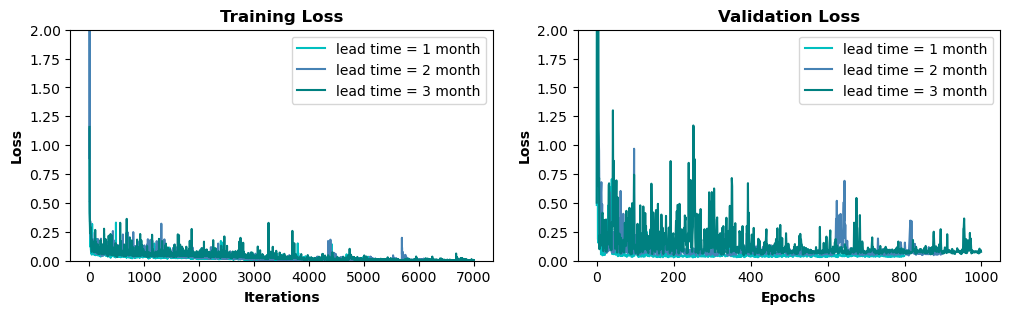

In [114]:
#Plots of training and validation loss
fig=plt.figure(figsize=(12,3))

plt.subplot(121)
plt.plot(Loss_test, label='lead time = 1 month', c='c')
plt.plot(Loss_test_ld2, label='lead time = 2 month', c='steelblue')
plt.plot(Loss_test_ld3, label='lead time = 3 month', c='teal')
plt.xlabel('Iterations', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Training Loss', fontweight='bold')
plt.ylim(0,2)
plt.legend()

plt.subplot(122)
plt.plot(Loss_valid, label='lead time = 1 month', c='c')
plt.plot(Loss_valid_ld2, label='lead time = 2 month', c='steelblue')
plt.plot(Loss_valid_ld3, label='lead time = 3 month', c='teal')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Validation Loss', fontweight='bold')
plt.ylim(0,2)
plt.legend()

plt.savefig('allvar_Losses.png', dpi=300)

In [23]:
#Fuction for reversing the normalization
def reverse_normalization(network_best_state, lead, n_channels, input_variables=False, var1_index=False, var2_index=False):
    Unet = UNet(input_channels=n_channels).to(device)
    Unet.load_state_dict(torch.load(network_best_state))
    
    data_loader_train, data_loader_valid, data_loader_test, x_test = dataset_creation_correct(lead, input_variables, var1_index, var2_index)
    input_variables, y_sic, sic_std, sic_mean, mask, y_times = data_preparation(lead_time=lead)
    
    yhat = Unet(x_test)
    
    pred = (yhat[:,0,:,:]*sic_std + sic_mean).detach().cpu()*mask[408:,:,:]
    y = (y_sic[408:,:,:]*sic_std + sic_mean).detach().cpu()*mask[408:,:,:]
    
    pred01 = np.copy(pred)
    pred01[pred01<0] = 0
    pred01[pred01>1] = 1
    
    diff = pred - y
    diff01 = pred01 -y.detach().numpy()
    
    
    Error, Error01 = [], []
    for i in range(len(y)):
        error = Mse(abs(np.nan_to_num(pred[i,:,:])), abs(np.nan_to_num(y[i,:,:])))
        error01 = Mse((np.nan_to_num(pred01[i,:,:])), np.nan_to_num(y[i,:,:]))
        Error.append(error)
        Error01.append(error01)
    
    return pred, pred01, y, diff, diff01, Error, y_times, Error01 

#### Example plots of the evolution of MSEs 

In [57]:
def plot_MSE_all1(network_best_state1, network_best_state2, network_best_state3, network_best_state4, network_best_state5, network_best_state6,
                 network_best_state7, network_best_state8, network_best_state9, n_channels1, n_channels2, n_channels3, in_var=False, var1=False, var2=False):
    
    ####two variables
    pred1, pred01_1, y1, diff1, diff01_1, Error1, y_time1, Error01_1_2v = reverse_normalization(network_best_state1, lead=1, n_channels=n_channels1, input_variables=in_var,
                                                                                   var1_index=var1[0], var2_index=var2[0])
    pred2, pred01_2, y2, diff2, diff01_2, Error2, y_time2, Error01_2_2v = reverse_normalization(network_best_state2, lead=2, n_channels=n_channels1, input_variables=in_var,
                                                                                   var1_index=var1[1], var2_index=var2[1])
    pred3, pred01_3, y3, diff3, diff01_3, Error3, y_time3, Error01_3_2v = reverse_normalization(network_best_state3, lead=3, n_channels=n_channels1, input_variables=in_var,
                                                                                   var1_index=var1[2], var2_index=var2[2])
    
    var2=False
    in_var=1
    ####one variable
    pred1, pred01_1, y1, diff1, diff01_1, Error1, y_time1, Error01_1_1v = reverse_normalization(network_best_state4, lead=1, n_channels=n_channels2, input_variables=in_var,
                                                                                   var1_index=var1[0], var2_index=var2)
    pred2, pred01_2, y2, diff2, diff01_2, Error2, y_time2, Error01_2_1v = reverse_normalization(network_best_state5, lead=2, n_channels=n_channels2, input_variables=in_var,
                                                                                   var1_index=var1[1], var2_index=var2)
    pred3, pred01_3, y3, diff3, diff01_3, Error3, y_time3, Error01_3_1v = reverse_normalization(network_best_state6, lead=3, n_channels=n_channels2, input_variables=in_var,
                                                                                   var1_index=var1[2], var2_index=var2)
    var1=False
    in_var=False
    ####three variables
    pred1, pred01_1, y1, diff1, diff01_1, Error1, y_time1, Error01_1_all = reverse_normalization(network_best_state7, lead=1, n_channels=n_channels3, input_variables=in_var,
                                                                                   var1_index=var1, var2_index=var2)
    pred2, pred01_2, y2, diff2, diff01_2, Error2, y_time2, Error01_2_all = reverse_normalization(network_best_state8, lead=2, n_channels=n_channels3, input_variables=in_var,
                                                                                   var1_index=var1, var2_index=var2)
    pred3, pred01_3, y3, diff3, diff01_3, Error3, y_time3, Error01_3_all = reverse_normalization(network_best_state9, lead=3, n_channels=n_channels3, input_variables=in_var,
                                                                                   var1_index=var1, var2_index=var2)
    
    timeline1 = sic_coarse.time_counter.values[411:456]
    timeline2 = sic_coarse.time_counter.values[412:456]
    timeline3 = sic_coarse.time_counter.values[413:456]
    
    fig = plt.figure(figsize=(23,3))
    
    plt.subplot(131)
    plt.plot(timeline1, Error01_1_1v, 'o-', c='teal', label='sic')
    plt.plot(timeline1, Error01_1_2v, 'o-', c='lightskyblue', label='sic, t2m')
    plt.plot(timeline1, Error01_1_all, 'o-', c='sandybrown', label='all')
    plt.title('MSEs - Lead time = 1', fontweight='bold')
    plt.ylabel('MSE')
    plt.xlabel('time')
    plt.legend()
    
    plt.subplot(132)
    plt.plot(timeline2, Error01_2_1v, 'o-', c='teal', label='sic')
    plt.plot(timeline2, Error01_2_2v, 'o-', c='lightskyblue', label='sic,t2m')
    plt.plot(timeline2, Error01_2_all, 'o-', c='sandybrown', label='all')
    plt.title('MSEs - Lead time = 2', fontweight='bold')
    plt.ylabel('MSE')
    plt.xlabel('time')
    plt.legend()
    
    plt.subplot(133)
    plt.plot(timeline3, Error01_3_1v, 'o-', c='teal', label='sst')
    plt.plot(timeline3, Error01_3_2v, 'o-', c='lightskyblue', label='sst, t2m')
    plt.plot(timeline3, Error01_3_all, 'o-', c='sandybrown', label='all')
    plt.title('MSEs - Lead time = 3', fontweight='bold')
    plt.ylabel('MSE')
    plt.xlabel('time')
    plt.legend()

torch.Size([408, 6, 64, 128])
torch.Size([408, 6, 64, 128])
torch.Size([408, 6, 64, 128])
torch.Size([408, 3, 64, 128])
torch.Size([408, 3, 64, 128])
torch.Size([408, 3, 64, 128])
torch.Size([408, 15, 64, 128])
torch.Size([408, 15, 64, 128])
torch.Size([408, 15, 64, 128])


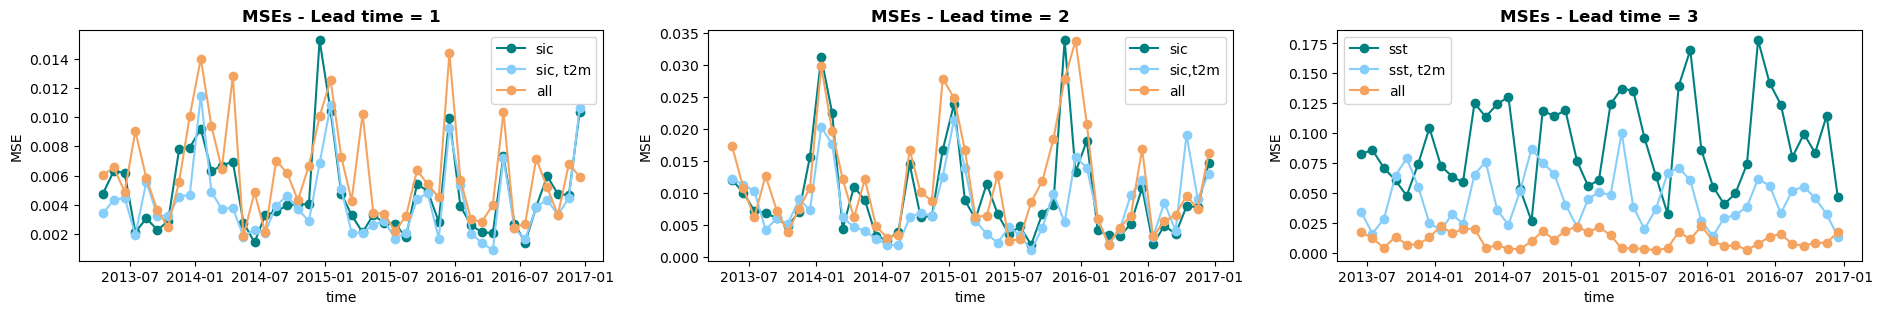

In [58]:
################ order: two variables, one variable, all variables:
plot_MSE_all1('bs_var2.pt', 'bs_var2_ld2.pt', 'bs_var2_ld3.pt', 'bs_var1.pt', 'bs_var1_ld2.pt', 'bs_var1_ld3.pt', 'bestState_ld1_all.pt', 'bestState_ld2_all.pt', 'bestState_ld3_all.pt', 
             n_channels1=6, n_channels2=3, n_channels3=15, in_var=2, var1=[4,4,1], var2=[1,1,0])
plt.savefig('MSE_allCases.png', dpi=300)

#### Example plots of the best and worse spatial differences

In [158]:
def Differences_plot(Best_state_ld1, Best_state_ld2, Best_state_ld3, n_channels=15, err01=True, in_var=False, var1=False, var2=False):
    
    fig = plt.figure(figsize=(14,6.5), tight_layout=True)
    
    
    leads = [1,2,3,1,2,3]

    ax1 = plt.subplot(2,3,1, projection=ccrs.SouthPolarStereo())
    ax2 = plt.subplot(2,3,2, projection=ccrs.SouthPolarStereo())
    ax3 = plt.subplot(2,3,3, projection=ccrs.SouthPolarStereo())
    ax4 = plt.subplot(2,3,4, projection=ccrs.SouthPolarStereo())
    ax5 = plt.subplot(2,3,5, projection=ccrs.SouthPolarStereo())
    ax6 = plt.subplot(2,3,6, projection=ccrs.SouthPolarStereo())
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]    
    
    texts = [AnchoredText('lead=1, best', loc=2, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False), 
             AnchoredText('lead=2, best', loc=2, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
             AnchoredText('lead=3, best', loc=2, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
             AnchoredText('lead=1, worst', loc=2, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
             AnchoredText('lead=2, worst', loc=2, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
             AnchoredText('lead=3, worst', loc=2, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False)]
    
    texts_dates = [AnchoredText('2014-05', loc=1, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
                   AnchoredText('2016-03', loc=1, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
                   AnchoredText('2015-08', loc=1, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
                   AnchoredText('2015-12', loc=1, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
                   AnchoredText('2015-12', loc=1, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False),
                   AnchoredText('2014-01', loc=1, borderpad=0.2, prop={'size': 11, 'fontweight': 'bold'}, frameon=False)]
    
    
    bests = [Best_state_ld1, Best_state_ld2, Best_state_ld3, Best_state_ld1, Best_state_ld2, Best_state_ld3]
    for i in range(6):
        pred, pred01, y, diff, diff01, Error, y_times, Error01 = reverse_normalization(bests[i], lead=leads[i], n_channels=n_channels, input_variables=in_var,
                                                                                       var1_index=var1, var2_index=var2)
        if err01==True:
            pred = pred01.copy()
            Error = Error01.copy()
            diff = diff01.copy()
        
        best, worst = np.where(Error == min(Error))[0][0], np.where(Error == max(Error))[0][0]
        if i>2:
            best=worst.copy()
        ax1 = plt.subplot(2,3,i+1, projection=ccrs.SouthPolarStereo())
        gl = ax1.gridlines(color='k', linestyle = 'dashed', draw_labels=False, dms=True, x_inline=False, y_inline=True)
        gl.top_labels = True
        gl.xlabel_style = {'rotation':0}
        ax1.add_feature(cp.feature.LAND, zorder=1, facecolor='grey', alpha=0.9)
        p = ax1.contourf(sic_coarse.lon, sic_coarse.lat, diff01[best,:,:], vmin=-0.7, vmax=0.7, levels=50,
                       extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu_r'))
        cbar = plt.colorbar(p, orientation='vertical', label='SIC', extend='both')
        ax1.coastlines()
        ax1.add_artist(texts[i])
        ax1.add_artist(texts_dates[i])
    fig.suptitle('Absolute differences between predictions and ground truth', fontsize=14, fontweight='bold')
    plt.savefig('Differences_all.png', dpi=300)
    plt.show()

torch.Size([408, 15, 64, 128])
torch.Size([408, 15, 64, 128])
torch.Size([408, 15, 64, 128])
torch.Size([408, 15, 64, 128])
torch.Size([408, 15, 64, 128])
torch.Size([408, 15, 64, 128])


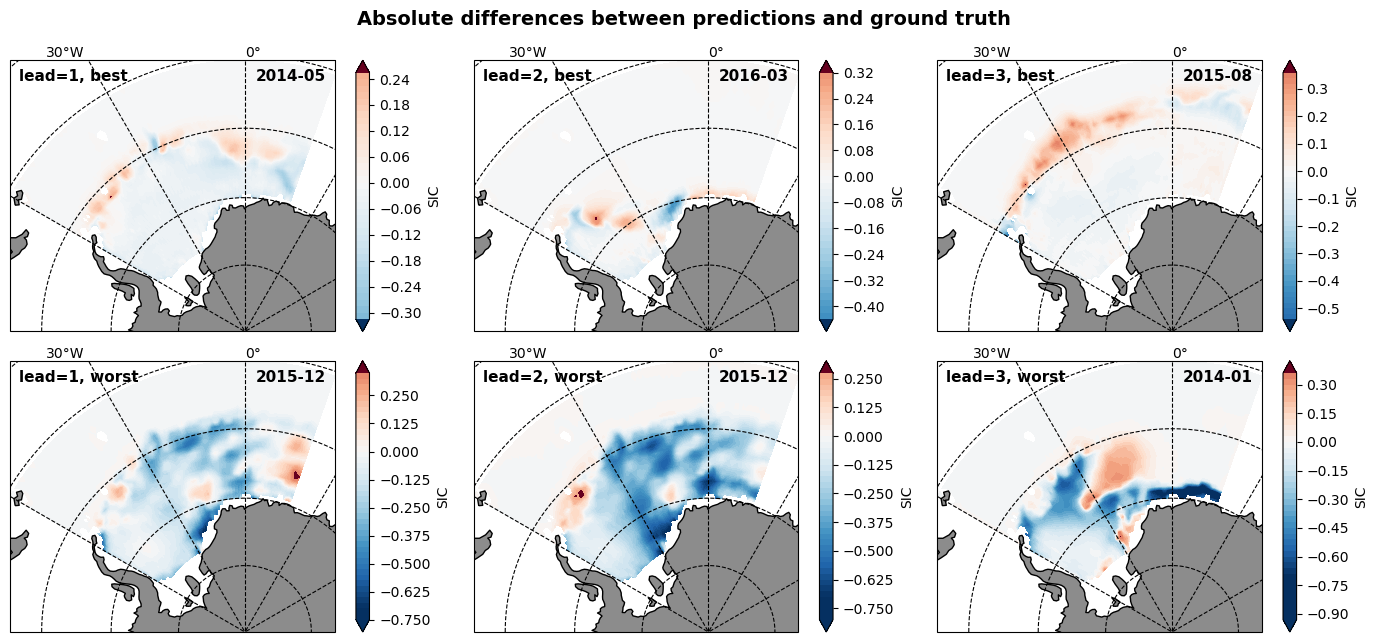

In [159]:
Differences_plot('bestState_ld1_all.pt', 'bestState_ld2_all.pt', 'bestState_ld3_all.pt')

#### Example plots of best and worst SIC and their differences

In [65]:
def SIC_plot(network_best_state, lead, n_channels, time, err01=False, in_var=False, var1=False, var2=False):
    
    pred, pred01, y, diff, diff01, Error, y_times, Error01 = reverse_normalization(network_best_state, lead, n_channels, input_variables=in_var, var1_index=var1, var2_index=var2)
    
    t, t_step = time, 411+time+lead-1
    
    if err01==True:
        pred = pred01.copy()
        Error = Error01.copy()
        diff = diff01.copy()
    
    best = np.where(Error == min(Error))[0][0]
    worst = np.where(Error == max(Error))[0][0]
    print(best)
    print(worst)

    fig    = plt.figure(figsize=(12,3), tight_layout=True)

    ax1 = plt.subplot(1,3,1, projection=ccrs.SouthPolarStereo())
    gl = ax1.gridlines(color='k', linestyle = 'dashed', draw_labels=False, dms=True, x_inline=False, y_inline=True)
    gl.top_labels = True
    gl.xlabel_style = {'rotation':0}
    ax1.add_feature(cp.feature.LAND, zorder=1, facecolor='grey', alpha=0.9)
    
    p = ax1.contourf(sic_coarse.lon, sic_coarse.lat, pred[t,:,:], vmin=0, vmax=1, levels=50,
                   extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.get_cmap('Blues_r'))
    cbar = plt.colorbar(p, orientation='vertical', label='$^\circ$C',extend='both', shrink=0.7)
    ax1.coastlines()
    ax1.set_title('{} - {}'.format('SIC prediction',str(sic_coarse.time_counter.values[t_step])[0:10]))
    #plt.show()


    ax2 = plt.subplot(1,3,2, projection=ccrs.SouthPolarStereo())
    gl = ax2.gridlines(color='k', linestyle = 'dashed', draw_labels=False, dms=True, x_inline=False, y_inline=True)
    gl.top_labels = True
    gl.xlabel_style = {'rotation':0}
    ax2.add_feature(cp.feature.LAND, zorder=1, facecolor='grey', alpha=0.9)
    p = ax2.contourf(sic_coarse.lon, sic_coarse.lat, y[t,:,:], vmin=0, vmax=1, levels=50,
                   extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.get_cmap('Blues_r'))

    cbar = plt.colorbar(p, orientation='vertical', label='$^\circ$C',extend='both', shrink=0.7)

    ax2.coastlines()
    ax2.set_title('{} - {}'.format('SIC ground truth',str(sic_coarse.time_counter.values[t_step])[0:10]))
    
    ax3 = plt.subplot(1,3,3, projection=ccrs.SouthPolarStereo())
    gl = ax3.gridlines(color='k', linestyle = 'dashed', draw_labels=False, dms=True, x_inline=False, y_inline=True)
    gl.top_labels = True
    gl.xlabel_style = {'rotation':0}
    ax3.add_feature(cp.feature.LAND, zorder=1, facecolor='grey', alpha=0.9)
    p = ax3.contourf(sic_coarse.lon, sic_coarse.lat, diff[t,:,:], vmin=-0.5, vmax=0.5, levels=50,
                   extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu_r'))
    cbar = plt.colorbar(p, orientation='vertical', label='$^\circ$C',extend='both', shrink=0.7)
    ax3.coastlines()
    ax3.set_title('{} - {}'.format('SIC diff',str(sic_coarse.time_counter.values[t_step])[0:10]))
    plt.show()

torch.Size([408, 15, 64, 128])
13
32


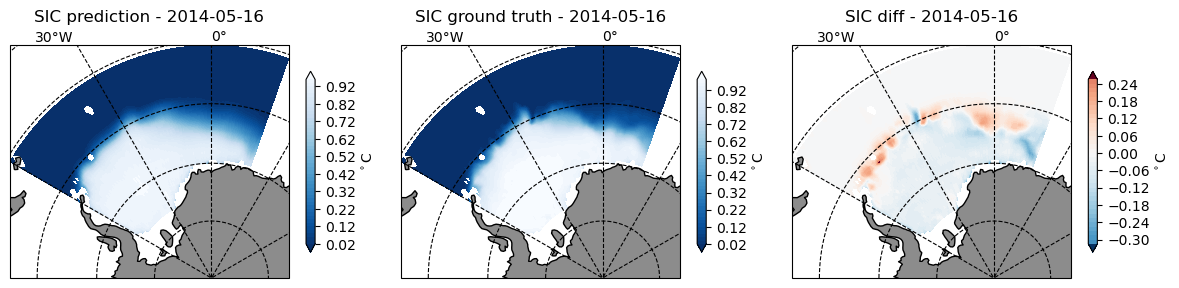

torch.Size([408, 15, 64, 128])
13
32


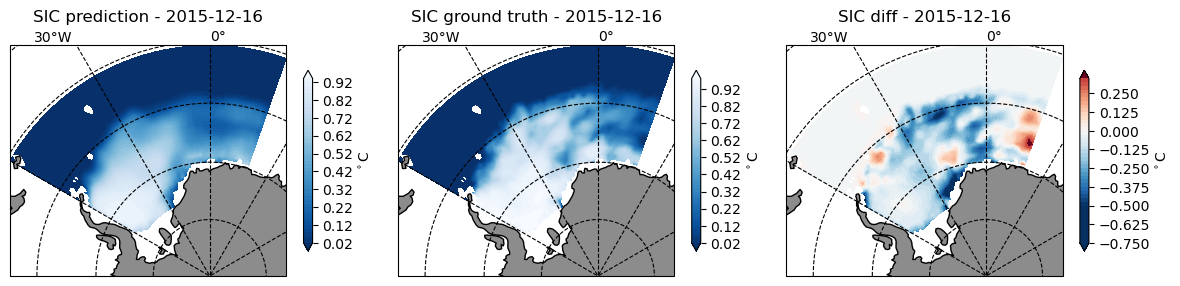

torch.Size([408, 15, 64, 128])
34
31


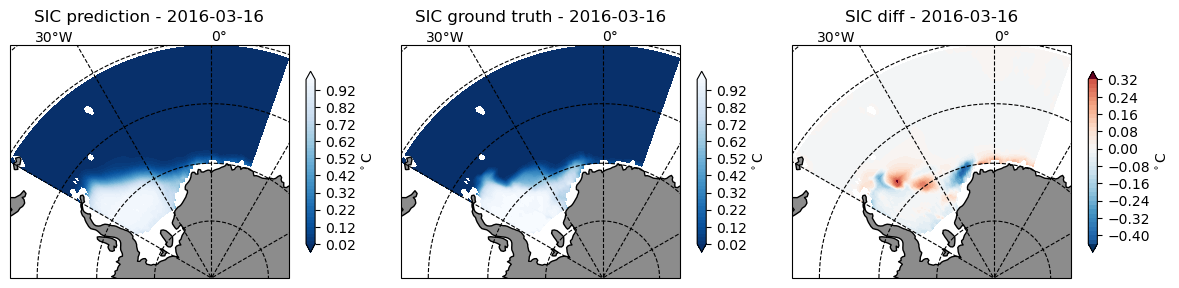

torch.Size([408, 15, 64, 128])
34
31


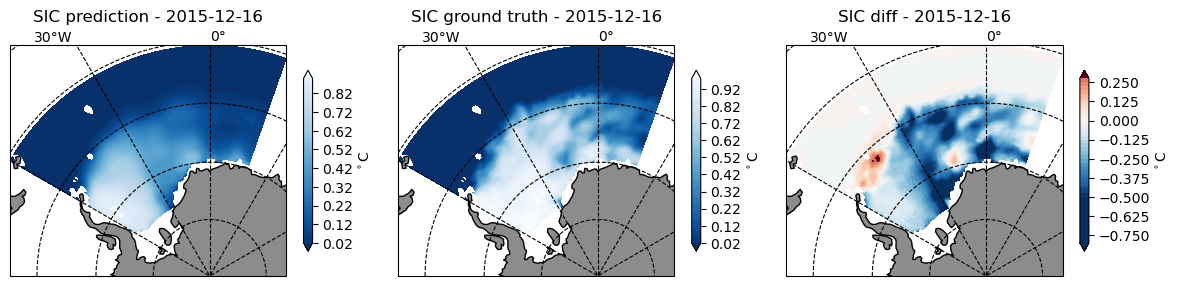

torch.Size([408, 15, 64, 128])
26
7


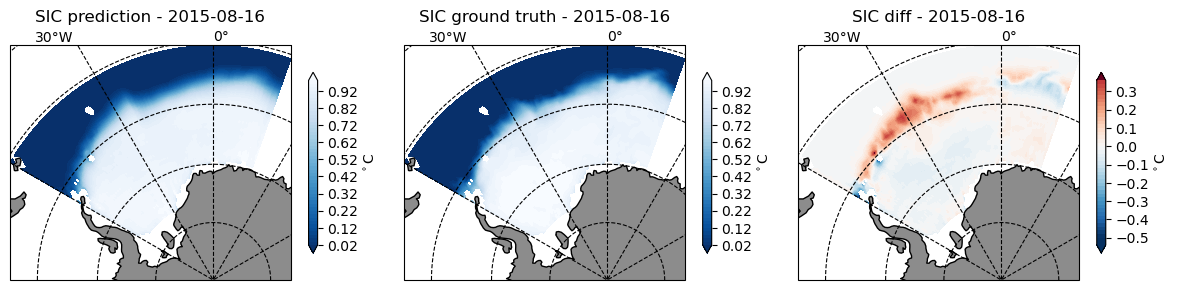

torch.Size([408, 15, 64, 128])
26
7


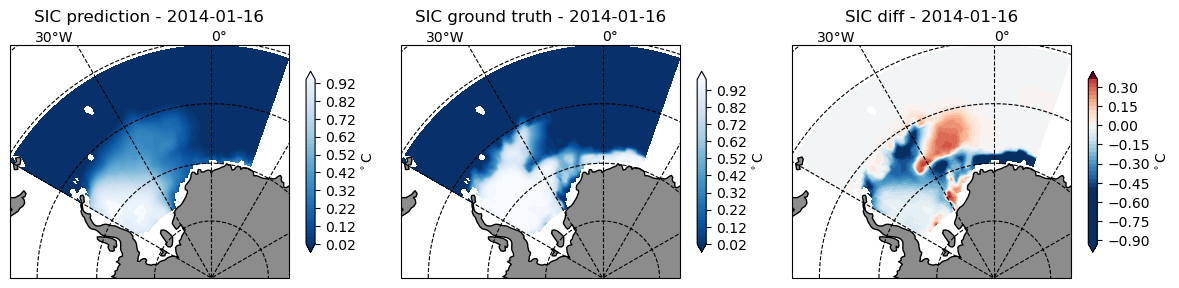

In [70]:
####### LEAD TIME = 1
#BEST
SIC_plot('bestState_ld1_all.pt', lead=1, n_channels=15, time=13, err01=True)
#WORST
SIC_plot('bestState_ld1_all.pt', lead=1, n_channels=15, time=32, err01=True)

###### LEAD TIME = 2
#BEST
SIC_plot('bestState_ld2_all.pt', lead=2, n_channels=15, time=34, err01=True)
#WORST
SIC_plot('bestState_ld2_all.pt', lead=2, n_channels=15, time=31, err01=True)

###### LEAD TIME = 3
#BEST
SIC_plot('bestState_ld3_all.pt', lead=3, n_channels=15, time=26, err01=True)
#WORST
SIC_plot('bestState_ld3_all.pt', lead=3, n_channels=15, time=7, err01=True)